#### Libraries Imported and Setup

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA GeForce RTX 3090


#### Model Architecture

##### Vision Transformer Model

In [3]:
class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :- 
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        # self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        # value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        # value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), key)
        
        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [4]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-
    
    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [5]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-
    
    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [6]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [7]:
# Not Exactly Same as Paper
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary 
    classification token and used to optimize the transformer model by applying Cross-Entropy 
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes) 
        return out

In [8]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|
    
    Args:
        patch_size: Length of square patch size 
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)
    
    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

##### ResNet Models

In [10]:
class ResidualBlockSmall(nn.Module):
    '''
    ResidualBlockSmall implements the smaller block of the Residual Networks. It optionally also downsamples
    the input according to the stride to match the output while adding the residual. The sequence of operations
    is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Output
      |                                                              |
      |-----------------Residual_Downsample (Optional)---------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels, height, width)
    
    Examples:
        >>> RBS = ResidualBlockSmall(input_channels, out_channels, residual_downsample, stride)
        >>> out = RBS(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels, height, width) | height, width depending on stride
        return out

In [11]:
class ResNetSmall(nn.Module):
    '''
    ResNetSmall consists of layers of the smaller residual block defined above (ResidualBlockSmall).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetSmall(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [12]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The 
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)
    
    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [13]:
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output. 
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [14]:
def ResNet34(input_channels, classes):
    '''
    Initalization of ResNet34 using the layers as mentioned in the paper and using ResNetSmall module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetSmall Object
    '''
    return ResNetSmall([3, 4, 6, 3], input_channels, classes)

In [15]:
def ResNet50(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.
    
    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

#### Data Loading Functions

In [16]:
def CIFAR100DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [17]:
def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR10 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.Resize((48, 48)),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

#### Training and Evaluation Functions

In [18]:
# Initializations of all the constants used in the training and testing process

lr = 0.003
batch_size = 256
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = 100 # All sequences must be less than 1000 including class token
embed_dim = 512
classes = 100
layers = 12
channels = 3
resnet_features_channels = 64
heads = 16
epochs = 100

In [19]:
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence 
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == 'VisionTransformer':
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

In [20]:
def evaluation(model, dataloader, criterion, resnet_features=None):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)
    
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

#### Model Initialization

Run either one the following subcells according to the models selected to train and test

##### Model - Vision Transformer

Recommended Values for the following Architecture

- patch_size = 4
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 3
- heads = 16

In [21]:
# Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads).to(device)

resnet_features = None

In [22]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

12842762

Recommended Values for the following Architecture

- patch_size = 7
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 64 (Resnet Features Channels)
- heads = 16

In [21]:
# Hybrid Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=resnet_features_channels,
    heads=heads).to(device)

resnet_features = ResNetFeatures().to(device).eval()

In [22]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

13365604

##### Model - ResNet50 or ResNet34

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet34 Architecture

model = ResNet34(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet50 Architecture

model = ResNet50(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

#### Model Training and Evaluation

##### CIFAR10 Dataset

In [24]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './data/' + model.name + '_CIFAR10_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.96it/s]


Epoch : 1 - acc: 0.2532 - loss : 1.9533



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.16it/s]


test acc: 0.3568 - test loss : 1.7210



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.91it/s]


Epoch : 2 - acc: 0.3891 - loss : 1.6439



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.90it/s]


test acc: 0.3855 - test loss : 1.7557



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.22it/s]


Epoch : 3 - acc: 0.4397 - loss : 1.5330



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.06it/s]


test acc: 0.4398 - test loss : 1.7506



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.21it/s]


Epoch : 4 - acc: 0.4664 - loss : 1.4630



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.71it/s]


test acc: 0.4421 - test loss : 1.7199



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.08it/s]


Epoch : 5 - acc: 0.4801 - loss : 1.4400



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.77it/s]


test acc: 0.4449 - test loss : 1.8179



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.29it/s]


Epoch : 6 - acc: 0.4994 - loss : 1.3902



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.20it/s]


test acc: 0.4574 - test loss : 1.7560



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.14it/s]


Epoch : 7 - acc: 0.5164 - loss : 1.3535



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.00it/s]


test acc: 0.4661 - test loss : 1.6523



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.37it/s]


Epoch : 8 - acc: 0.5189 - loss : 1.3398



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.40it/s]


test acc: 0.4857 - test loss : 1.5711



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.05it/s]


Epoch : 9 - acc: 0.5392 - loss : 1.2869



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.90it/s]


test acc: 0.5008 - test loss : 1.6040



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.41it/s]


Epoch : 10 - acc: 0.5415 - loss : 1.2795



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.73it/s]


test acc: 0.4817 - test loss : 1.6860



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.03it/s]


Epoch : 11 - acc: 0.5545 - loss : 1.2540



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.93it/s]


test acc: 0.4700 - test loss : 1.7334



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.91it/s]


Epoch : 12 - acc: 0.5648 - loss : 1.2222



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.00it/s]


test acc: 0.4911 - test loss : 1.6657



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.27it/s]


Epoch : 13 - acc: 0.5658 - loss : 1.2163



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.09it/s]


test acc: 0.5189 - test loss : 1.5110



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.27it/s]


Epoch : 14 - acc: 0.5736 - loss : 1.1993



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.75it/s]


test acc: 0.5056 - test loss : 1.4992



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.23it/s]


Epoch : 15 - acc: 0.5799 - loss : 1.1819



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.25it/s]


test acc: 0.5038 - test loss : 1.5788



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.11it/s]


Epoch : 16 - acc: 0.5916 - loss : 1.1621



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.14it/s]


test acc: 0.5371 - test loss : 1.4314



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.21it/s]


Epoch : 17 - acc: 0.5910 - loss : 1.1525



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.63it/s]


test acc: 0.5130 - test loss : 1.6093



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.17it/s]


Epoch : 18 - acc: 0.5975 - loss : 1.1383



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.95it/s]


test acc: 0.5317 - test loss : 1.4564



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.30it/s]


Epoch : 19 - acc: 0.6064 - loss : 1.1174



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.88it/s]


test acc: 0.5344 - test loss : 1.4602



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.99it/s]


Epoch : 20 - acc: 0.6109 - loss : 1.0985



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.73it/s]


test acc: 0.5180 - test loss : 1.5254



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.19it/s]


Epoch : 21 - acc: 0.6103 - loss : 1.1046



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.70it/s]


test acc: 0.5374 - test loss : 1.4770



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.19it/s]


Epoch : 22 - acc: 0.6173 - loss : 1.0826



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.12it/s]


test acc: 0.5349 - test loss : 1.5276



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.17it/s]


Epoch : 23 - acc: 0.6166 - loss : 1.0792



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.81it/s]


test acc: 0.5355 - test loss : 1.5192



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.29it/s]


Epoch : 24 - acc: 0.6226 - loss : 1.0646



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.75it/s]


test acc: 0.5585 - test loss : 1.4667



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.11it/s]


Epoch : 25 - acc: 0.6221 - loss : 1.0653



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.07it/s]


test acc: 0.5744 - test loss : 1.3475



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.16it/s]


Epoch : 26 - acc: 0.6305 - loss : 1.0499



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.24it/s]


test acc: 0.5601 - test loss : 1.3915



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.08it/s]


Epoch : 27 - acc: 0.6320 - loss : 1.0423



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.89it/s]


test acc: 0.5666 - test loss : 1.3585



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.22it/s]


Epoch : 28 - acc: 0.6401 - loss : 1.0240



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.17it/s]


test acc: 0.5389 - test loss : 1.5117



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.00it/s]


Epoch : 29 - acc: 0.6413 - loss : 1.0167



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.98it/s]


test acc: 0.5766 - test loss : 1.3575



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.81it/s]


Epoch : 30 - acc: 0.6418 - loss : 1.0153



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.45it/s]


test acc: 0.5752 - test loss : 1.3816



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.98it/s]


Epoch : 31 - acc: 0.6445 - loss : 1.0038



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.18it/s]


test acc: 0.5639 - test loss : 1.3806



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.90it/s]


Epoch : 32 - acc: 0.6493 - loss : 0.9914



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.07it/s]


test acc: 0.5527 - test loss : 1.4647



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.10it/s]


Epoch : 33 - acc: 0.6502 - loss : 0.9927



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.76it/s]


test acc: 0.5851 - test loss : 1.3294



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.21it/s]


Epoch : 34 - acc: 0.6562 - loss : 0.9764



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.17it/s]


test acc: 0.5813 - test loss : 1.3207



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.92it/s]


Epoch : 35 - acc: 0.6559 - loss : 0.9740



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.02it/s]


test acc: 0.5609 - test loss : 1.4504



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.20it/s]


Epoch : 36 - acc: 0.6607 - loss : 0.9685



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.08it/s]


test acc: 0.5826 - test loss : 1.3015



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.11it/s]


Epoch : 37 - acc: 0.6627 - loss : 0.9568



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.87it/s]


test acc: 0.5568 - test loss : 1.4142



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.24it/s]


Epoch : 38 - acc: 0.6615 - loss : 0.9585



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.96it/s]


test acc: 0.5661 - test loss : 1.3866



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.04it/s]


Epoch : 39 - acc: 0.6644 - loss : 0.9488



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.09it/s]


test acc: 0.5856 - test loss : 1.3644



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.14it/s]


Epoch : 40 - acc: 0.6739 - loss : 0.9317



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.93it/s]


test acc: 0.5737 - test loss : 1.3803



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.93it/s]


Epoch : 41 - acc: 0.6716 - loss : 0.9337



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.31it/s]


test acc: 0.5732 - test loss : 1.4294



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.28it/s]


Epoch : 42 - acc: 0.6728 - loss : 0.9257



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.56it/s]


test acc: 0.5733 - test loss : 1.3815



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.14it/s]


Epoch : 43 - acc: 0.6756 - loss : 0.9234



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.88it/s]


test acc: 0.5784 - test loss : 1.3312



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.11it/s]


Epoch : 44 - acc: 0.6795 - loss : 0.9118



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.59it/s]


test acc: 0.5819 - test loss : 1.3671



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.21it/s]


Epoch : 45 - acc: 0.6819 - loss : 0.9106



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.42it/s]


test acc: 0.5983 - test loss : 1.3014



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.01it/s]


Epoch : 46 - acc: 0.6824 - loss : 0.9000



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.27it/s]


test acc: 0.5819 - test loss : 1.3761



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.02it/s]


Epoch : 47 - acc: 0.6807 - loss : 0.9057



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.54it/s]


test acc: 0.6065 - test loss : 1.2623



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.05it/s]


Epoch : 48 - acc: 0.6895 - loss : 0.8846



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.26it/s]


test acc: 0.5944 - test loss : 1.3445



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.98it/s]


Epoch : 49 - acc: 0.6881 - loss : 0.8849



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.66it/s]


test acc: 0.5938 - test loss : 1.3201



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.92it/s]


Epoch : 50 - acc: 0.6913 - loss : 0.8839



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.75it/s]


test acc: 0.6155 - test loss : 1.2237



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.04it/s]


Epoch : 51 - acc: 0.6875 - loss : 0.8827



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.82it/s]


test acc: 0.5948 - test loss : 1.3271



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.11it/s]


Epoch : 52 - acc: 0.6926 - loss : 0.8752



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.57it/s]


test acc: 0.6099 - test loss : 1.2855



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.12it/s]


Epoch : 53 - acc: 0.6955 - loss : 0.8640



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.68it/s]


test acc: 0.6124 - test loss : 1.2304



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.35it/s]


Epoch : 54 - acc: 0.6985 - loss : 0.8562



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.96it/s]


test acc: 0.5804 - test loss : 1.3799



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.07it/s]


Epoch : 55 - acc: 0.6994 - loss : 0.8552



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.96it/s]


test acc: 0.6060 - test loss : 1.2870



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.37it/s]


Epoch : 56 - acc: 0.6998 - loss : 0.8530



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.09it/s]


test acc: 0.6133 - test loss : 1.2690



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.13it/s]


Epoch : 57 - acc: 0.7002 - loss : 0.8473



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.41it/s]


test acc: 0.6014 - test loss : 1.3137



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.06it/s]


Epoch : 58 - acc: 0.7018 - loss : 0.8470



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.53it/s]


test acc: 0.5989 - test loss : 1.3498



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.14it/s]


Epoch : 59 - acc: 0.7067 - loss : 0.8342



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.91it/s]


test acc: 0.6192 - test loss : 1.2616



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.04it/s]


Epoch : 60 - acc: 0.7070 - loss : 0.8304



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.31it/s]


test acc: 0.6033 - test loss : 1.2912



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.03it/s]


Epoch : 61 - acc: 0.7063 - loss : 0.8265



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.44it/s]


test acc: 0.6190 - test loss : 1.1907



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.97it/s]


Epoch : 62 - acc: 0.7126 - loss : 0.8189



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.18it/s]


test acc: 0.6183 - test loss : 1.2501



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.05it/s]


Epoch : 63 - acc: 0.7136 - loss : 0.8154



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.91it/s]


test acc: 0.6157 - test loss : 1.2413



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.13it/s]


Epoch : 64 - acc: 0.7117 - loss : 0.8154



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.14it/s]


test acc: 0.6104 - test loss : 1.2783



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.11it/s]


Epoch : 65 - acc: 0.7145 - loss : 0.8068



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.86it/s]


test acc: 0.6187 - test loss : 1.2365



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.16it/s]


Epoch : 66 - acc: 0.7145 - loss : 0.8058



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.78it/s]


test acc: 0.6149 - test loss : 1.2545



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.60it/s]


Epoch : 67 - acc: 0.7140 - loss : 0.8100



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.66it/s]


test acc: 0.6336 - test loss : 1.1628



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.30it/s]


Epoch : 68 - acc: 0.7192 - loss : 0.7969



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.11it/s]


test acc: 0.6136 - test loss : 1.2547



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.39it/s]


Epoch : 69 - acc: 0.7197 - loss : 0.7905



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.34it/s]


test acc: 0.6190 - test loss : 1.2220



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.90it/s]


Epoch : 70 - acc: 0.7215 - loss : 0.7896



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.24it/s]


test acc: 0.6075 - test loss : 1.2724



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.80it/s]


Epoch : 71 - acc: 0.7245 - loss : 0.7848



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.73it/s]


test acc: 0.6063 - test loss : 1.3187



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.16it/s]


Epoch : 72 - acc: 0.7259 - loss : 0.7794



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.15it/s]


test acc: 0.6129 - test loss : 1.2592



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.16it/s]


Epoch : 73 - acc: 0.7272 - loss : 0.7721



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.50it/s]


test acc: 0.6144 - test loss : 1.2624



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.20it/s]


Epoch : 74 - acc: 0.7260 - loss : 0.7792



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.18it/s]


test acc: 0.6258 - test loss : 1.1743



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.09it/s]


Epoch : 75 - acc: 0.7256 - loss : 0.7788



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.75it/s]


test acc: 0.6199 - test loss : 1.2629



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.34it/s]


Epoch : 76 - acc: 0.7310 - loss : 0.7626



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.13it/s]


test acc: 0.6210 - test loss : 1.2572



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.89it/s]


Epoch : 77 - acc: 0.7274 - loss : 0.7734



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.84it/s]


test acc: 0.6297 - test loss : 1.2048



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.20it/s]


Epoch : 78 - acc: 0.7314 - loss : 0.7635



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.19it/s]


test acc: 0.6236 - test loss : 1.2328



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.04it/s]


Epoch : 79 - acc: 0.7347 - loss : 0.7542



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.83it/s]


test acc: 0.6356 - test loss : 1.2108



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.87it/s]


Epoch : 80 - acc: 0.7373 - loss : 0.7441



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.48it/s]


test acc: 0.6351 - test loss : 1.1753



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.24it/s]


Epoch : 81 - acc: 0.7359 - loss : 0.7490



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.26it/s]


test acc: 0.6011 - test loss : 1.3308



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.10it/s]


Epoch : 82 - acc: 0.7415 - loss : 0.7372



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.40it/s]


test acc: 0.6073 - test loss : 1.3522



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.95it/s]


Epoch : 83 - acc: 0.7383 - loss : 0.7396



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.00it/s]


test acc: 0.6382 - test loss : 1.1973



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.02it/s]


Epoch : 84 - acc: 0.7397 - loss : 0.7358



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.82it/s]


test acc: 0.6180 - test loss : 1.2749



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.16it/s]


Epoch : 85 - acc: 0.7409 - loss : 0.7328



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.61it/s]


test acc: 0.6248 - test loss : 1.1879



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.09it/s]


Epoch : 86 - acc: 0.7425 - loss : 0.7287



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.49it/s]


test acc: 0.6379 - test loss : 1.1969



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.07it/s]


Epoch : 87 - acc: 0.7469 - loss : 0.7189



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.61it/s]


test acc: 0.6444 - test loss : 1.1551



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.88it/s]


Epoch : 88 - acc: 0.7456 - loss : 0.7224



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.30it/s]


test acc: 0.6274 - test loss : 1.2220



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.29it/s]


Epoch : 89 - acc: 0.7461 - loss : 0.7179



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.12it/s]


test acc: 0.6402 - test loss : 1.1840



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.04it/s]


Epoch : 90 - acc: 0.7475 - loss : 0.7179



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.12it/s]


test acc: 0.6356 - test loss : 1.2194



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.15it/s]


Epoch : 91 - acc: 0.7493 - loss : 0.7167



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.99it/s]


test acc: 0.6183 - test loss : 1.2399



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.23it/s]


Epoch : 92 - acc: 0.7512 - loss : 0.7052



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.75it/s]


test acc: 0.6197 - test loss : 1.2940



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.72it/s]


Epoch : 93 - acc: 0.7528 - loss : 0.7002



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.01it/s]


test acc: 0.6322 - test loss : 1.2275



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.16it/s]


Epoch : 94 - acc: 0.7537 - loss : 0.6938



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.12it/s]


test acc: 0.6283 - test loss : 1.2385



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.20it/s]


Epoch : 95 - acc: 0.7557 - loss : 0.6918



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.56it/s]


test acc: 0.6438 - test loss : 1.1978



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.94it/s]


Epoch : 96 - acc: 0.7581 - loss : 0.6884



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.24it/s]


test acc: 0.6234 - test loss : 1.2921



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.06it/s]


Epoch : 97 - acc: 0.7565 - loss : 0.6908



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.88it/s]


test acc: 0.6043 - test loss : 1.3809



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.09it/s]


Epoch : 98 - acc: 0.7579 - loss : 0.6838



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.77it/s]


test acc: 0.6426 - test loss : 1.2209



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.05it/s]


Epoch : 99 - acc: 0.7609 - loss : 0.6803



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.52it/s]


test acc: 0.6157 - test loss : 1.3595



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.96it/s]


Epoch : 100 - acc: 0.7553 - loss : 0.6888



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.69it/s]


test acc: 0.6344 - test loss : 1.1993



In [25]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

13342474

##### CIFAR100 Dataset

In [ ]:
train_dataloader = CIFAR100DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR100DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './checkpoints/' + model.name + '_CIFAR100_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 20.93it/s]


Epoch : 1 - acc: 0.0100 - loss : 4.6120



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.58it/s]


test acc: 0.0103 - test loss : 4.5999



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.17it/s]


Epoch : 2 - acc: 0.0177 - loss : 4.5620



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.36it/s]


test acc: 0.0197 - test loss : 4.4989



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.24it/s]


Epoch : 3 - acc: 0.0217 - loss : 4.4521



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.69it/s]


test acc: 0.0239 - test loss : 4.3742



100%|█████████████████████████████████████████| 196/196 [00:09<00:00, 21.35it/s]


Epoch : 4 - acc: 0.0269 - loss : 4.3282



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.24it/s]


test acc: 0.0279 - test loss : 4.3293



 54%|█████████████████████▉                   | 105/196 [00:04<00:04, 22.00it/s]

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

##### Saving accuracy

In [ ]:
import csv

dataset = 'cifar100'
path = './results/'
model_name = 'light_pretrained'

with open(path+'train_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in train_accs:
        wr.writerow([point])
        
        
with open(path+'test_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in test_accs:
        wr.writerow([point])

##### Plotting Results

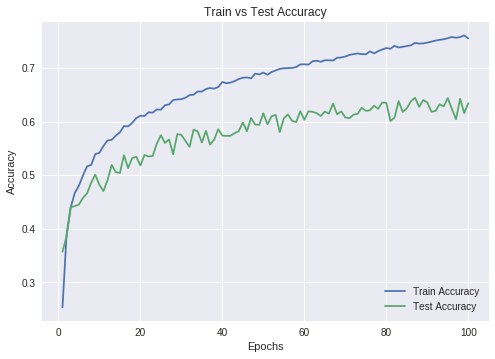

In [33]:
#CIFAR10
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

In [ ]:
#CIFAR100
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')